In [1]:
import numpy as np
import keras
from keras import layers
from tqdm import tqdm
import tensorflow as tf
# 禁用性能统计信息
tf.config.run_functions_eagerly(True)

#### 获取数据mnist

In [2]:
import os
download_path = os.path.join(os.getcwd(), r'./../data/keras_mnist_datasets')

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
n_residual_blocks = 5
# The data, split between train and test sets
(x, _), (y, _) = keras.datasets.mnist.load_data(path=download_path)
# Concatenate all the images together
data = np.concatenate((x, y), axis=0)
# Round all pixel values less than 33% of the max 256 value to 0
# anything above this value gets rounded up to 1 so that all values are either
# 0 or 1
data = np.where(data < (0.33 * 256), 0, 1)
data = data.astype(np.float32)

#### 构建模型

In [5]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = tf.shape(self.conv.kernel)
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [7]:
inputs = keras.Input(shape=input_shape, batch_size=128)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")

pixel_cnn.summary()
pixel_cnn.fit(
    x=data, y=data, batch_size=64, epochs=30, validation_split=0.1, verbose=2
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(128, 28, 28, 1)]        0         
                                                                 
 pixel_conv_layer_9 (PixelC  (128, 28, 28, 128)        6400      
 onvLayer)                                                       
                                                                 
 residual_block_5 (Residual  (128, 28, 28, 128)        98624     
 Block)                                                          
                                                                 
 residual_block_6 (Residual  (128, 28, 28, 128)        98624     
 Block)                                                          
                                                                 
 residual_block_7 (Residual  (128, 28, 28, 128)        98624     
 Block)                                                    

KeyboardInterrupt: 

#### 生成图像

  0%|          | 0/28 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


  4%|▎         | 1/28 [00:02<01:15,  2.80s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 2/28 [00:05<01:06,  2.55s/it]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 3/28 [00:07<01:01,  2.46s/it]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 4/28 [00:09<00:58,  2.43s/it]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 5/28 [00:12<00:55,  2.39s/it]

1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 6/28 [00:14<00:53,  2.43s/it]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 7/28 [00:17<00:50,  2.42s/it]

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 8/28 [00:19<00:48,  2.45s/it]

1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 9/28 [00:22<00:46,  2.44s/it]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 10/28 [00:24<00:43,  2.43s/it]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 11/28 [00:26<00:41,  2.42s/it]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 12/28 [00:29<00:38,  2.40s/it]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 13/28 [00:31<00:35,  2.39s/it]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 14/28 [00:33<00:33,  2.37s/it]

1/1 [==============================] - 0s 55ms/step


 54%|█████▎    | 15/28 [00:36<00:30,  2.38s/it]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 16/28 [00:38<00:28,  2.37s/it]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 17/28 [00:41<00:26,  2.38s/it]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 18/28 [00:43<00:23,  2.37s/it]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 19/28 [00:45<00:21,  2.38s/it]

1/1 [==============================] - 0s 56ms/step


 71%|███████▏  | 20/28 [00:48<00:19,  2.39s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 21/28 [00:50<00:16,  2.39s/it]

1/1 [==============================] - 0s 54ms/step


 79%|███████▊  | 22/28 [00:52<00:14,  2.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 23/28 [00:55<00:11,  2.39s/it]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 24/28 [00:57<00:09,  2.37s/it]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 25/28 [01:00<00:07,  2.48s/it]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 26/28 [01:02<00:04,  2.48s/it]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 27/28 [01:05<00:02,  2.48s/it]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 28/28 [01:07<00:00,  2.42s/it]


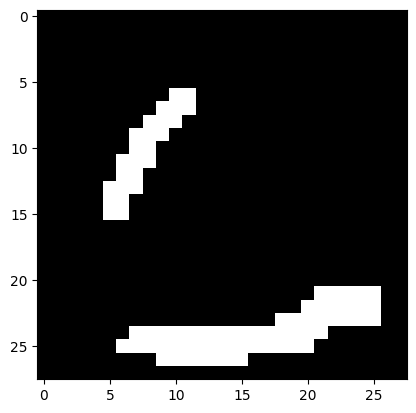

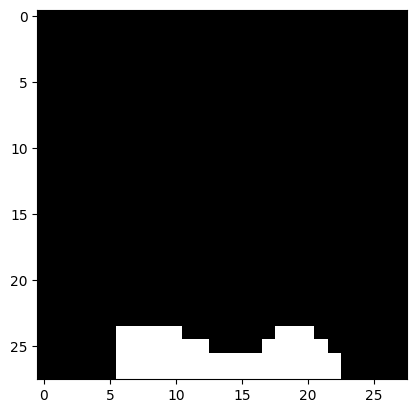

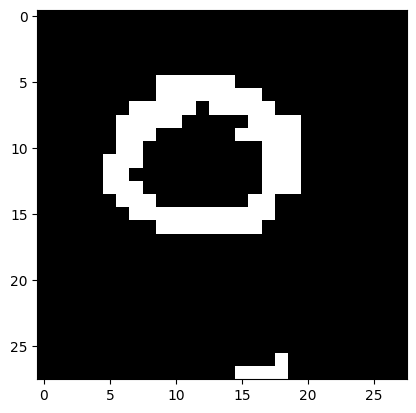

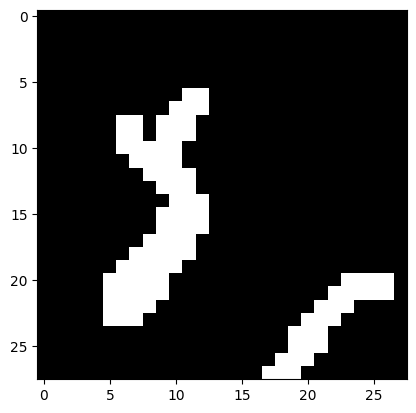

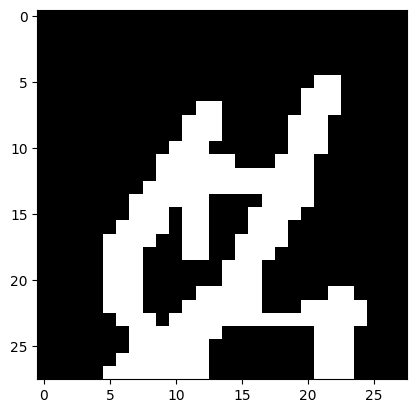

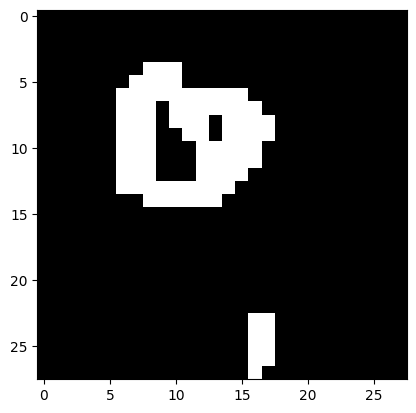

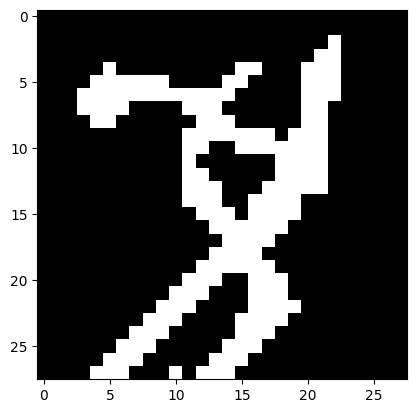

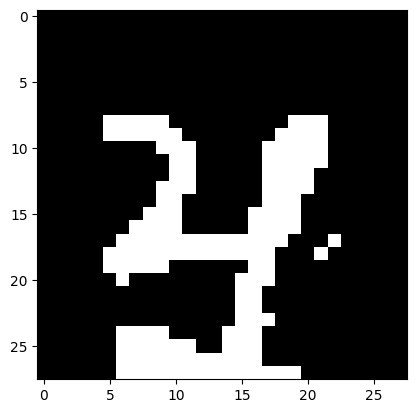

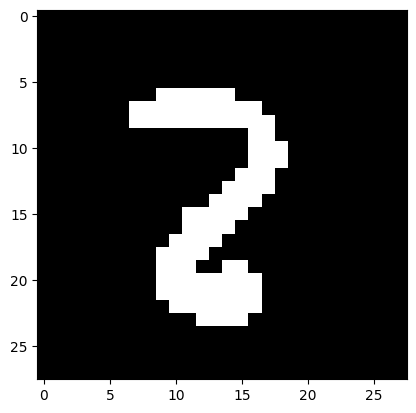

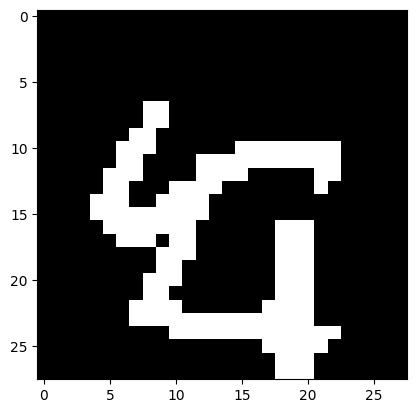

In [8]:
from IPython.display import Image, display
import matplotlib.pyplot as plt


# Create an empty array of pixels.
batch = 10
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.keras.backend.random_uniform(probs.shape)
            )


def deprocess_image(x):
    # Stack the single channeled black and white image to rgb values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



def show_image(data):
    plt.imshow(data)
    plt.show()



# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    image=deprocess_image(np.squeeze(pic, -1))
    show_image(image)
